In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [7]:
obj = sc.read_h5ad('../../../../../External_datasets/mouse_brain_all_cells_20200625_with_annotations.h5ad')
obj.X = obj.X.toarray()
obj = obj[obj.obs["Cell broad annotation"]=="Ext"]

obj = obj[obj.obs["Cell sub annotation"]!="Ext_Unk_1"]
obj = obj[obj.obs["Cell sub annotation"]!="Ext_Unk_2"]
obj = obj[obj.obs["Cell sub annotation"]!="Ext_Unk_3"]

In [8]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 12598 cells


In [9]:
new_sub_annotation = []
for c in obj.obs["Cell sub annotation"].tolist():
    if c in ['Ext_Amy_1', 'Ext_Amy_2']:
        new_sub_annotation.append('Ext_Amy')
        
    elif c in ['Ext_Hpc_CA1', 'Ext_Hpc_CA2', 'Ext_Hpc_CA3']:
        new_sub_annotation.append('Ext_Hpc_CA')
        
    elif c in ['Ext_Hpc_DG1', 'Ext_Hpc_DG2']:
        new_sub_annotation.append('Ext_Hpc_DG')
        
    elif c in ['Ext_L5_1', 'Ext_L5_2', 'Ext_L5_3']:
        new_sub_annotation.append('Ext_L5')
        
    elif c in ['Ext_Thal_1', 'Ext_Thal_2']:
        new_sub_annotation.append('Ext_Thal')
        
    else:
        new_sub_annotation.append(c)
obj.obs["Cell sub annotation"] = new_sub_annotation
obj.obs["Cell sub annotation"] = obj.obs["Cell sub annotation"].astype("category")

Trying to set attribute `.obs` of view, copying.


#### Data preparation

In [10]:
sf.data_preparation(obj)

#### Removing general genes

In [11]:
s1 = time.time()

In [12]:
obj = sf.remove_general_genes(obj, species='mouse')

#### Removing house-keeping genes

http://www.housekeeping.unicamp.br/?homePageGlobal

In [13]:
obj = sf.remove_housekeepingenes(obj, path="../../../data/house_keeping_genes_Mouse_cortex.txt")

#### Removing genes expressed in less than 30% within groups

In [14]:
obj = sf.remove_features_pct(obj, group_by="Cell sub annotation", pct=0.3)

#### Removing genes expressed in more than 50% in a given group where genes are expressed for more 75% within a given group

In [15]:
obj = sf.remove_features_pct_2groups(obj, group_by="Cell sub annotation", pct1=0.75, pct2=0.5)

#### Revert PCA

In [16]:
obj = sf.scale_filter_features(obj, n_components=None, filter_expression=True)

Fraction passing PCA: 0.9735165272799682


In [17]:
obj.var.set_index(obj.var["SYMBOL"], inplace=True, drop=False)
obj.var.index.name = None

#### DNN

In [18]:
s2 = time.time()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                156480    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0

101/101 [==============================] - 1s 6ms/step - loss: 0.1907 - accuracy: 0.9855 - auc: 0.9999 - precision: 0.9960 - recall: 0.9518 - val_loss: 0.1983 - val_accuracy: 0.9520 - val_auc: 0.9982 - val_precision: 0.9692 - val_recall: 0.9373

Epoch 00019: val_loss improved from 0.21052 to 0.19832, saving model to weights/best_model_Cell sub annotation.h5
Epoch 20/100
101/101 [==============================] - 1s 6ms/step - loss: 0.1800 - accuracy: 0.9832 - auc: 0.9999 - precision: 0.9956 - recall: 0.9552 - val_loss: 0.1882 - val_accuracy: 0.9536 - val_auc: 0.9982 - val_precision: 0.9696 - val_recall: 0.9381

Epoch 00020: val_loss improved from 0.19832 to 0.18822, saving model to weights/best_model_Cell sub annotation.h5
Epoch 21/100
101/101 [==============================] - 1s 6ms/step - loss: 0.1560 - accuracy: 0.9876 - auc: 0.9999 - precision: 0.9955 - recall: 0.9615 - val_loss: 0.1787 - val_accuracy: 0.9571 - val_auc: 0.9982 - val_precision: 0.9693 - val_recall: 0.9409

Epoch 00


Epoch 00042: val_loss did not improve from 0.14908
Epoch 43/100
101/101 [==============================] - 1s 6ms/step - loss: 0.0527 - accuracy: 0.9923 - auc: 1.0000 - precision: 0.9959 - recall: 0.9876 - val_loss: 0.1478 - val_accuracy: 0.9556 - val_auc: 0.9971 - val_precision: 0.9606 - val_recall: 0.9476

Epoch 00043: val_loss improved from 0.14908 to 0.14779, saving model to weights/best_model_Cell sub annotation.h5
Epoch 44/100
101/101 [==============================] - 1s 6ms/step - loss: 0.0495 - accuracy: 0.9936 - auc: 1.0000 - precision: 0.9956 - recall: 0.9889 - val_loss: 0.1593 - val_accuracy: 0.9520 - val_auc: 0.9972 - val_precision: 0.9591 - val_recall: 0.9484

Epoch 00044: val_loss did not improve from 0.14779
Epoch 45/100
101/101 [==============================] - 1s 6ms/step - loss: 0.0457 - accuracy: 0.9933 - auc: 1.0000 - precision: 0.9960 - recall: 0.9901 - val_loss: 0.1594 - val_accuracy: 0.9560 - val_auc: 0.9960 - val_precision: 0.9584 - val_recall: 0.9512

Epoch 

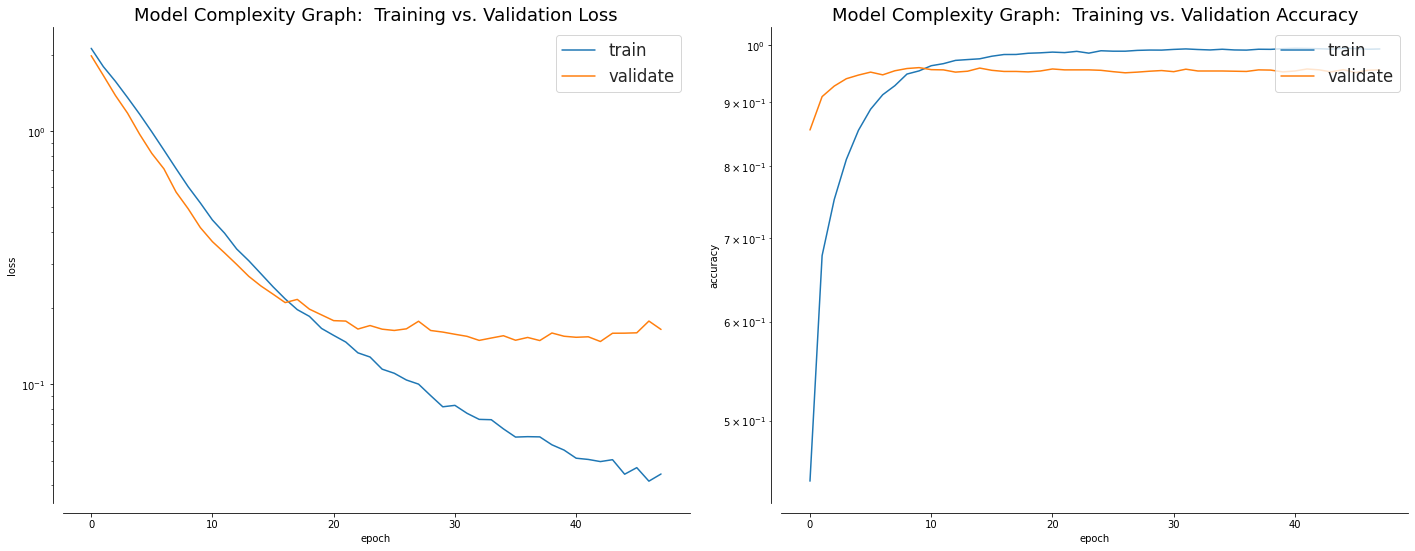

<Figure size 432x288 with 0 Axes>

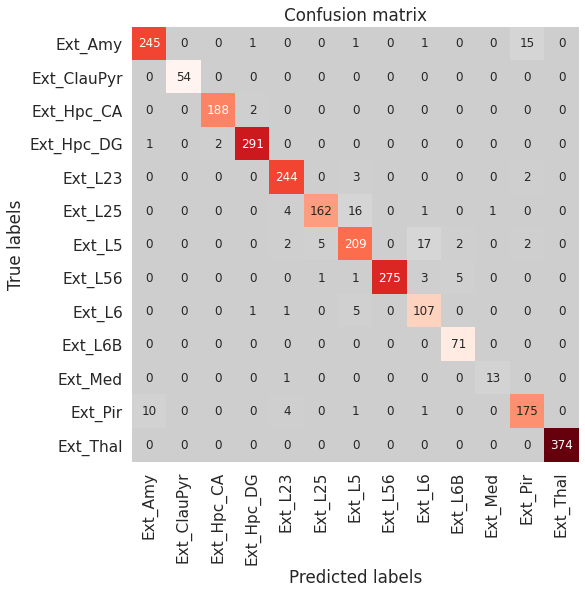

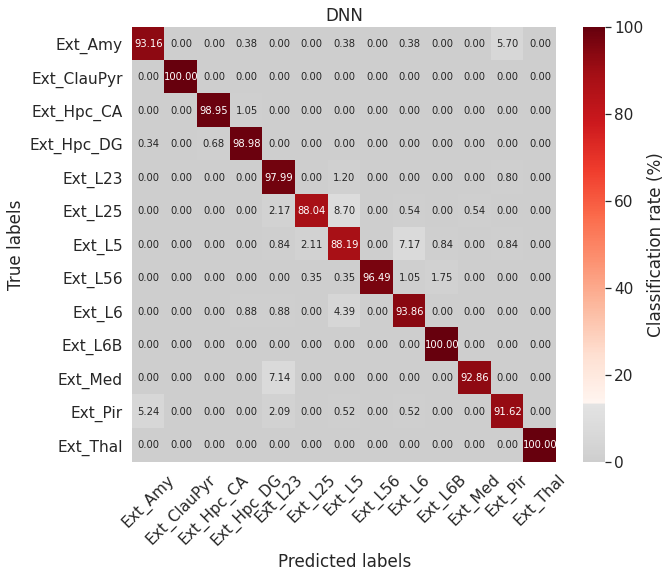

              precision    recall  f1-score   support

     Ext_Amy       0.96      0.93      0.94       263
 Ext_ClauPyr       1.00      1.00      1.00        54
  Ext_Hpc_CA       0.99      0.99      0.99       190
  Ext_Hpc_DG       0.99      0.99      0.99       294
     Ext_L23       0.95      0.98      0.97       249
     Ext_L25       0.96      0.88      0.92       184
      Ext_L5       0.89      0.88      0.88       237
     Ext_L56       1.00      0.96      0.98       285
      Ext_L6       0.82      0.94      0.88       114
     Ext_L6B       0.91      1.00      0.95        71
     Ext_Med       0.93      0.93      0.93        14
     Ext_Pir       0.90      0.92      0.91       191
    Ext_Thal       1.00      1.00      1.00       374

    accuracy                           0.96      2520
   macro avg       0.95      0.95      0.95      2520
weighted avg       0.96      0.96      0.96      2520

79/79 [==============================] - 0s 1ms/step - loss: 0.1478 - accuracy:

In [19]:
sf.DNN(obj, group_by="Cell sub annotation", model=None, balance=True, verbose=True, save=True)

#### Shap value

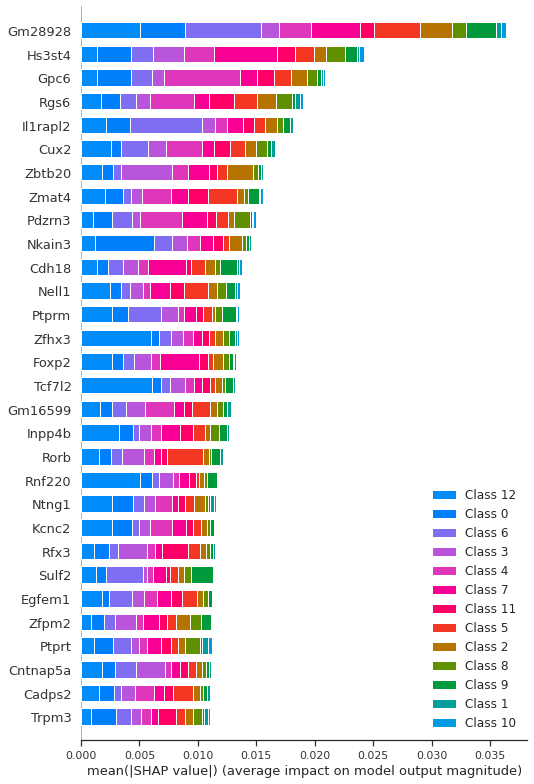

In [20]:
selectedGenes, selectedGenes_dict = sf.run_shap(obj, group_by="Cell sub annotation", model=None, verbose=True, pct=0.1, restrict_top=("local", 20))

In [21]:
e2 = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

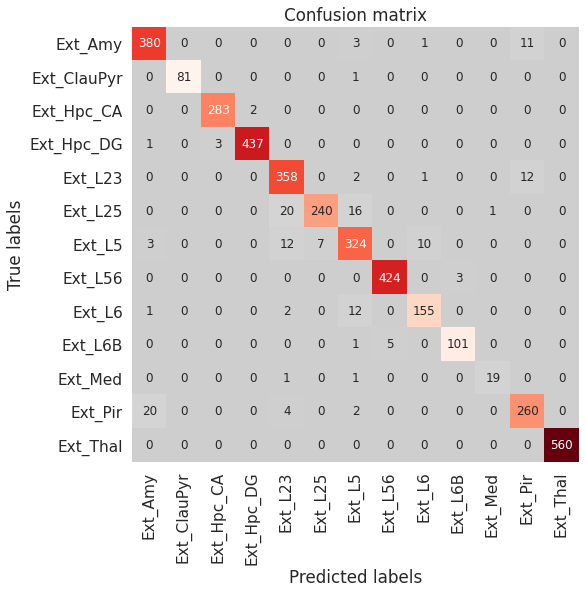

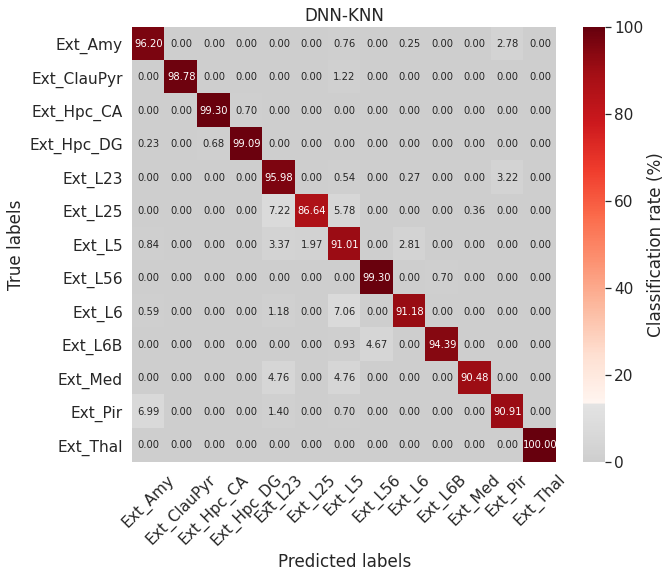

Accuracy: 0.9582010582010582: Misclassification: 0.041798941798941835
              precision    recall  f1-score   support

     Ext_Amy       0.94      0.96      0.95       395
 Ext_ClauPyr       1.00      0.99      0.99        82
  Ext_Hpc_CA       0.99      0.99      0.99       285
  Ext_Hpc_DG       1.00      0.99      0.99       441
     Ext_L23       0.90      0.96      0.93       373
     Ext_L25       0.97      0.87      0.92       277
      Ext_L5       0.90      0.91      0.90       356
     Ext_L56       0.99      0.99      0.99       427
      Ext_L6       0.93      0.91      0.92       170
     Ext_L6B       0.97      0.94      0.96       107
     Ext_Med       0.95      0.90      0.93        21
     Ext_Pir       0.92      0.91      0.91       286
    Ext_Thal       1.00      1.00      1.00       560

    accuracy                           0.96      3780
   macro avg       0.96      0.95      0.95      3780
weighted avg       0.96      0.96      0.96      3780



In [22]:
sf.run_classifiers(obj, group_by="Cell sub annotation", genes=selectedGenes, classifier="KNN", balance=True, title="DNN-KNN", save=True)

#### Sorting genes per cluster

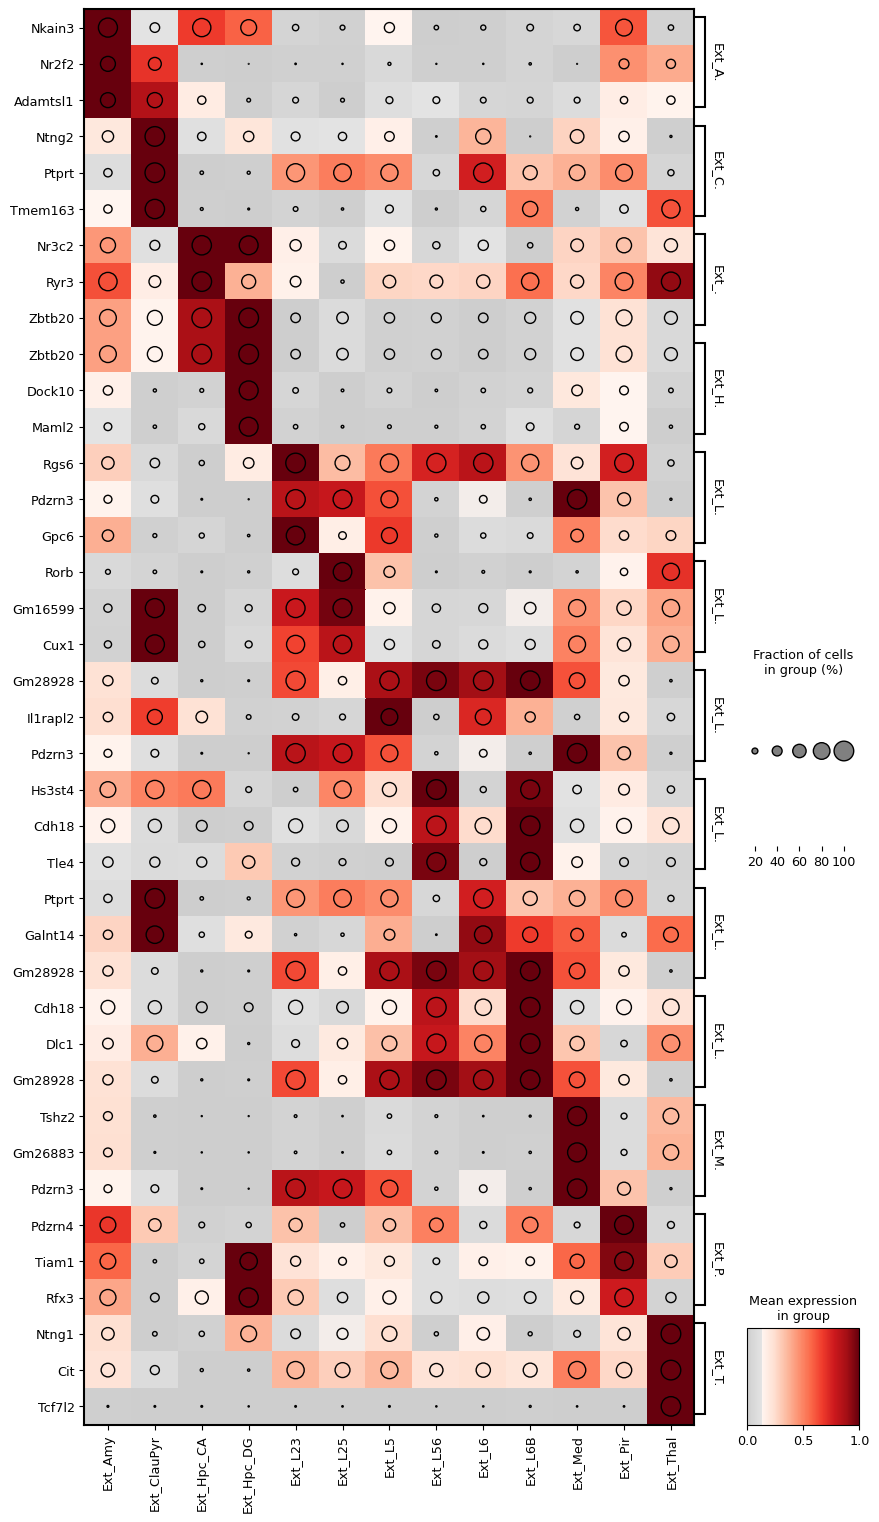

In [23]:
axs, selectedGenes_top_dict = sf.sort_and_plot(obj, selectedGenes, group_by="Cell sub annotation", top=3, figsize=(10,18))

In [24]:
e1 = time.time()

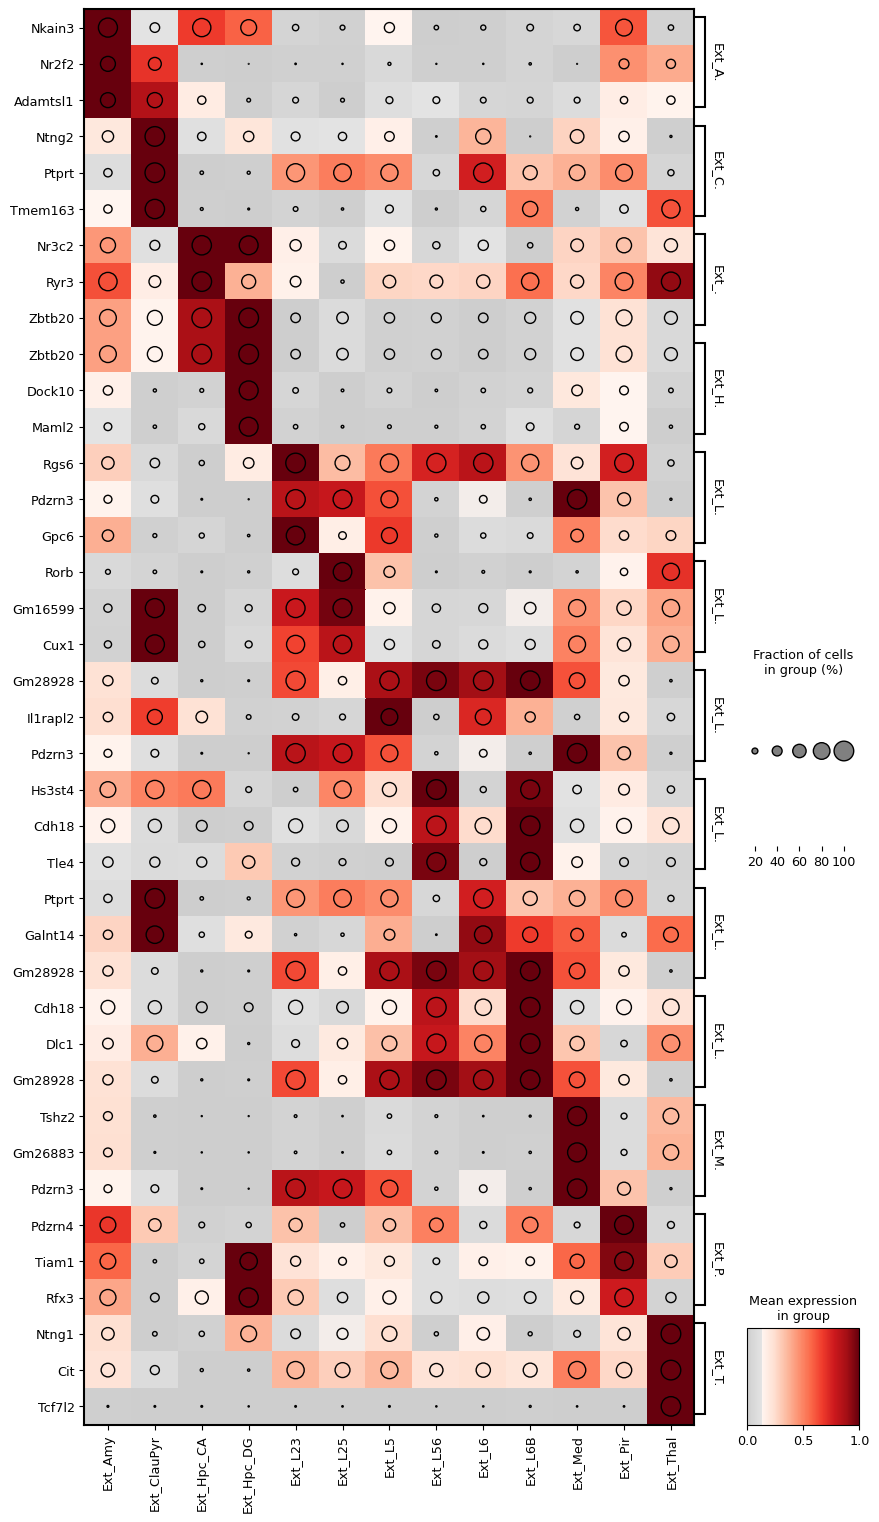

In [25]:
axs.savefig("Figures/DNN_top5_perGroup.pdf")

# Elapsed time

In [26]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

4889 genes across 12598 cells


In [27]:
print('Elapsed time (s): ', e1-s1)

Elapsed time (s):  673.1150159835815


In [28]:
print('Elapsed time (s): ', e2-s2)

Elapsed time (s):  519.7248229980469
